# Feature Engineering

---

1. Import packages
2. Load data
3. Feature engineering
* Dealing with outlier
* Imbalanced dataset: use balanced classweight in randomforest

---

# 1. Import packages

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

---
# 2. Load data

In [2]:
df = pd.read_csv('clean_data_after_eda.csv')
df["date_activ"] = pd.to_datetime(df["date_activ"], format='%Y-%m-%d')
df["date_end"] = pd.to_datetime(df["date_end"], format='%Y-%m-%d')
df["date_modif_prod"] = pd.to_datetime(df["date_modif_prod"], format='%Y-%m-%d')
df["date_renewal"] = pd.to_datetime(df["date_renewal"], format='%Y-%m-%d')

In [3]:
df.head(3)

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,num_years_antig,origin_up,pow_max,churn,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1,0.124787,0.100749,0.06653,40.942265,22.35201,14.90134
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0,0.149609,0.007124,0.00000,44.311375,0.00000,0.00000
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0,0.170512,0.088421,0.00000,44.385450,0.00000,0.00000


---

# 3. Feature engineering

### Difference between off-peak prices in December and preceding January

Below is the code created by your colleague to calculate the feature described above. Use this code to re-create this feature and then think about ways to build on this feature to create features with a higher predictive power.

In [4]:
price_df = pd.read_csv('price_data.csv')
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')
price_df.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


In [5]:
# Group off-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), 
                jan_prices.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff.head()

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001


In [6]:
df = pd.merge(left=df, right=diff,on='id')
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,pow_max,churn,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,43.648,1,0.124787,0.100749,0.066530,40.942265,22.352010,14.901340,0.020057,3.700961
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,13.800,0,0.149609,0.007124,0.000000,44.311375,0.000000,0.000000,-0.003767,0.177779
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,13.856,0,0.170512,0.088421,0.000000,44.385450,0.000000,0.000000,-0.004670,0.177779
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,13.200,0,0.151210,0.000000,0.000000,44.400265,0.000000,0.000000,-0.004547,0.177779
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,19.800,0,0.124174,0.103638,0.072865,40.688156,24.412893,16.275263,-0.006192,0.162916


## 3.1. Deal with Outliers

Define outliers: not within 3 sigma confidence level

Categorize numerical features as...
* Consumption features
* Time features: Maybe consider longevity only
* Price features

Make new dataframe: df_engineered to avoid removing outliers from one feature affect the other features' outliers

In [7]:
# Save any changes to df_engineered dataframe: preserve statistics of other features
df_engineered = df.copy()
df_engineered.drop(['date_activ', 'date_end', 'date_modif_prod', 'date_renewal'],axis=1,inplace=True)

## 3.1.1. Consumptions

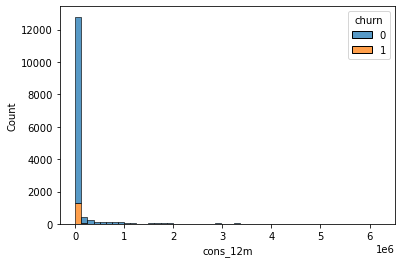

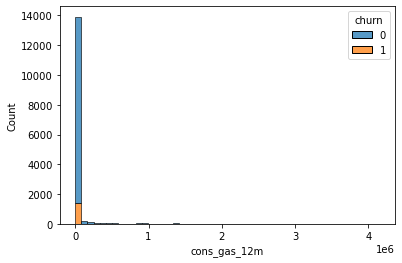

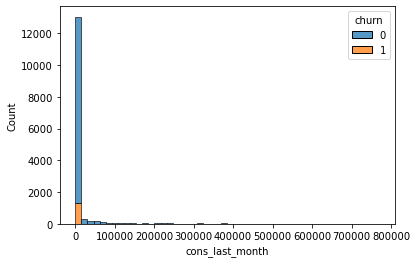

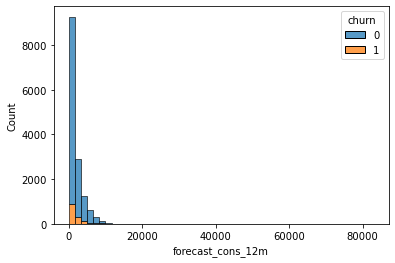

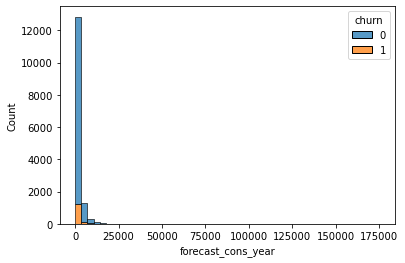

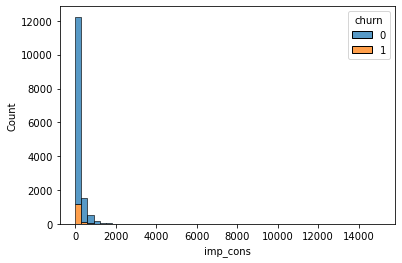

In [8]:
con_cols = []
for col in df.columns:
    if 'cons' in col:
        plt.figure()
        sns.histplot(x=col, data=df,bins=50, hue='churn', multiple='stack')
        con_cols.append(col)

They are all highly skewed: since we are defining outliers with z-scores, better be normalized.
* Taking log could be a good strategy
* Count the 0's

In [9]:
df[con_cols].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
cons_12m,14606.0,159220.286252,573465.264198,0.0,5674.750,14115.500,40763.75,6207104.00
cons_gas_12m,14606.0,28092.375325,162973.059057,0.0,0.000,0.000,0.00,4154590.00
cons_last_month,14606.0,16090.269752,64364.196422,0.0,0.000,792.500,3383.00,771203.00
forecast_cons_12m,14606.0,1868.614880,2387.571531,0.0,494.995,1112.875,2401.79,82902.83
forecast_cons_year,14606.0,1399.762906,3247.786255,0.0,0.000,314.000,1745.75,175375.00
imp_cons,14606.0,152.786896,341.369366,0.0,0.000,37.395,193.98,15042.79


In [10]:
for col in con_cols:
    print(f"{col}\t{100*df[col].value_counts()[0]/len(df):.2f}%")

cons_12m	0.80%
cons_gas_12m	82.12%
cons_last_month	34.12%
forecast_cons_12m	2.10%
forecast_cons_year	42.09%
imp_cons	42.24%


It is not good idea to remove all zeros because some of them have considerable amount of zeros. Let's add 1 and then take log instead.

In [11]:
# Switch the consumption featurs to log (x+1)
for col in con_cols:
    df_engineered[col]=np.log(df_engineered[col]+1)
df_engineered.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,...,pow_max,churn,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0.000000,10.914124,0.000000,0.000000,0.000000,0.0,1.78,0.114481,...,43.648,1,0.124787,0.100749,0.066530,40.942265,22.352010,14.901340,0.020057,3.700961
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,8.446985,0.000000,0.000000,5.252012,0.000000,0.0,16.27,0.145711,...,13.800,0,0.149609,0.007124,0.000000,44.311375,0.000000,0.000000,-0.003767,0.177779
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,6.300786,0.000000,0.000000,3.891004,0.000000,0.0,38.72,0.165794,...,13.856,0,0.170512,0.088421,0.000000,44.385450,0.000000,0.000000,-0.004670,0.177779
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,7.368340,0.000000,0.000000,5.484963,0.000000,0.0,19.83,0.146694,...,13.200,0,0.151210,0.000000,0.000000,44.400265,0.000000,0.000000,-0.004547,0.177779
4,149d57cf92fc41cf94415803a877cb4b,MISSING,8.395252,0.000000,6.267201,6.101999,6.267201,0.0,131.73,0.116900,...,19.800,0,0.124174,0.103638,0.072865,40.688156,24.412893,16.275263,-0.006192,0.162916


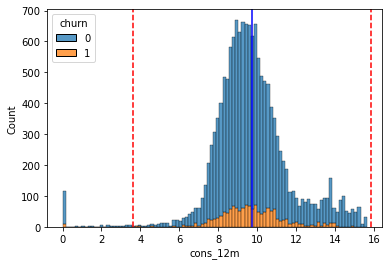

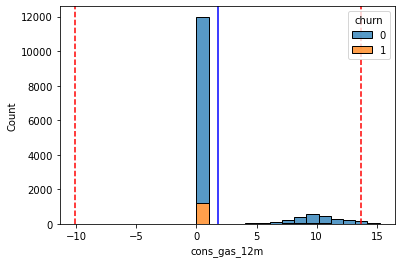

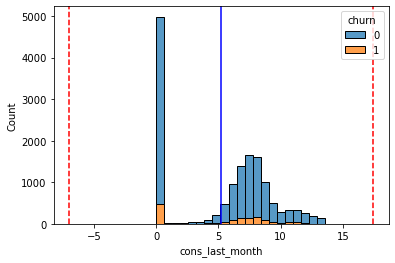

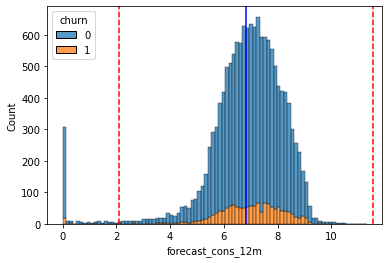

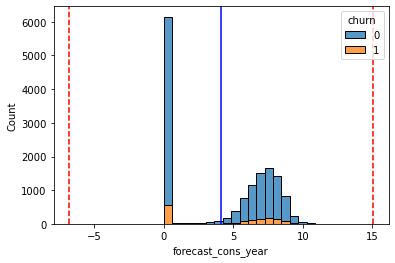

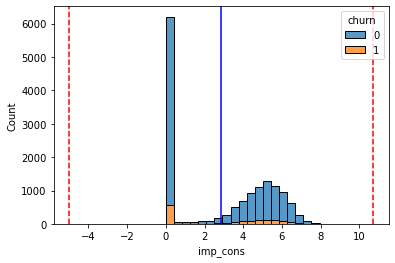

In [12]:
for col in con_cols:
    m = df_engineered[col].mean()
    s = df_engineered[col].std()
    
    upper_lim = m+3*s
    lower_lim = m-3*s
    
    plt.figure()
    sns.histplot(x=col, data=df_engineered, hue='churn', multiple='stack')
    plt.axvline(m, 0,1, color='b')
    plt.axvline(upper_lim, 0,1, color='r',linestyle='--')
    plt.axvline(lower_lim, 0,1, color='r',linestyle='--')

It would be more reasonable to make catergrized feature: "non-zero-XX-consumption" with 0 or 1 entries.

This will force our tree to consider if consumption is zero or not

In [13]:
def check_non_zero(x):
    if x == 0:
        return 0
    else:
        return 1

for col in con_cols:
    df_engineered[f'non_zero_{col}']=df_engineered[col].map(lambda x:check_non_zero(x))

In [14]:
df_engineered.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,...,price_peak_fix,price_mid_peak_fix,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,non_zero_cons_12m,non_zero_cons_gas_12m,non_zero_cons_last_month,non_zero_forecast_cons_12m,non_zero_forecast_cons_year,non_zero_imp_cons
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0.000000,10.914124,0.000000,0.000000,0.000000,0.0,1.78,0.114481,...,22.352010,14.901340,0.020057,3.700961,0,1,0,0,0,0
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,8.446985,0.000000,0.000000,5.252012,0.000000,0.0,16.27,0.145711,...,0.000000,0.000000,-0.003767,0.177779,1,0,0,1,0,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,6.300786,0.000000,0.000000,3.891004,0.000000,0.0,38.72,0.165794,...,0.000000,0.000000,-0.004670,0.177779,1,0,0,1,0,0
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,7.368340,0.000000,0.000000,5.484963,0.000000,0.0,19.83,0.146694,...,0.000000,0.000000,-0.004547,0.177779,1,0,0,1,0,0
4,149d57cf92fc41cf94415803a877cb4b,MISSING,8.395252,0.000000,6.267201,6.101999,6.267201,0.0,131.73,0.116900,...,24.412893,16.275263,-0.006192,0.162916,1,0,1,1,1,1


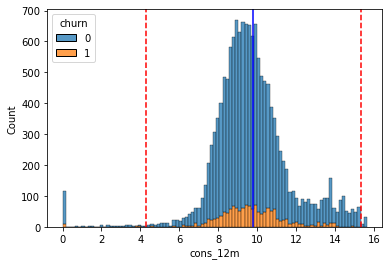

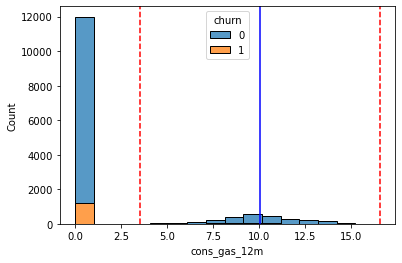

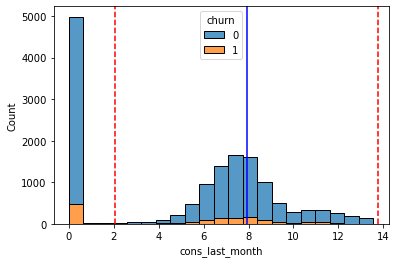

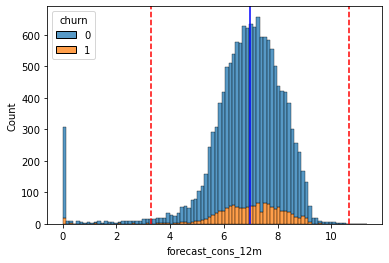

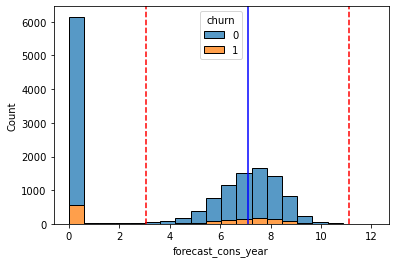

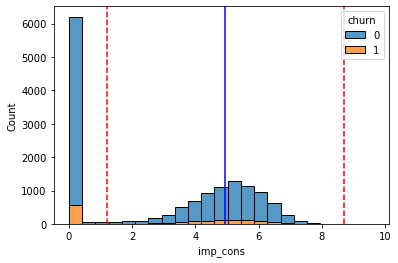

In [15]:
# Do the same plot above again with non-zero values

for col in con_cols:
    m=df_engineered[df_engineered[f'non_zero_{col}']==1][col].mean()
    s=df_engineered[df_engineered[f'non_zero_{col}']==1][col].std()

    upper_lim = m+3*s
    lower_lim = m-3*s
    
    plt.figure()
    sns.histplot(x=col, data=df_engineered, hue='churn', multiple='stack')
    plt.axvline(m, 0,1, color='b')
    plt.axvline(upper_lim, 0,1, color='r',linestyle='--')
    plt.axvline(lower_lim, 0,1, color='r',linestyle='--')

The range looks a bit more reasonable! Take the outliers out!

In [16]:
# if log value is not zero or within the range
for col in con_cols:
    # Calculate upper and lower limit from df
    m=df_engineered[df_engineered[f'non_zero_{col}']==1][col].mean()
    s=df_engineered[df_engineered[f'non_zero_{col}']==1][col].std()
    upper_lim = m+3*s
    lower_lim = m-3*s
    
    # Trim data in df_engineered with upper and lower lim
    df_engineered[col] = np.log(df[(np.log(df[col]+1)<upper_lim)&(np.log(df[col]+1)>lower_lim)|(df[col]==0)][col]+1)
    
df_engineered.dropna(axis=0,inplace=True)
len(df_engineered)/len(df)

0.9772696152266191

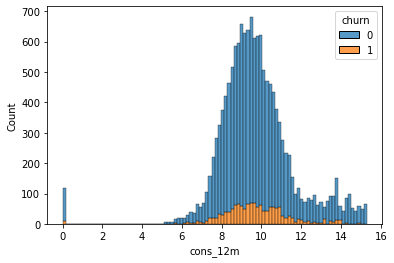

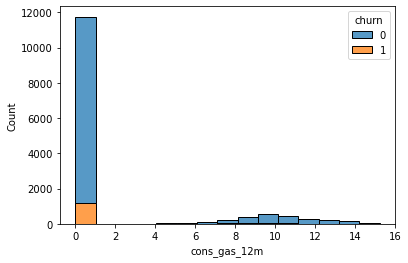

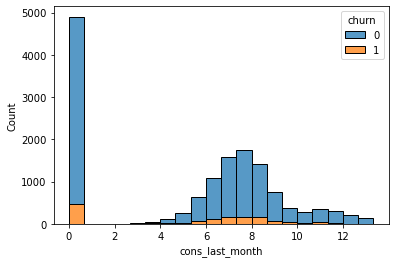

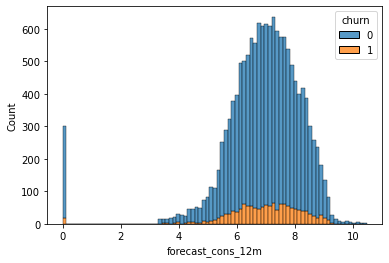

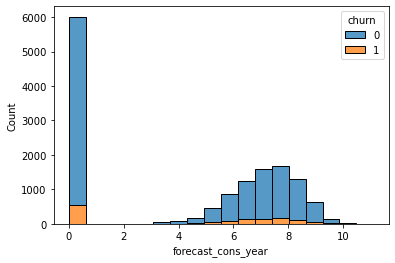

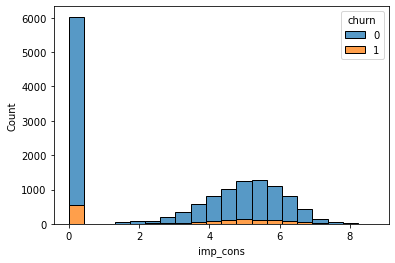

In [17]:
# Double Check if they are nicely trimmed by visualization
for col in con_cols:
    plt.figure()
    sns.histplot(x=col, data=df_engineered, hue='churn', multiple='stack')

## 3.1.2. Tenure

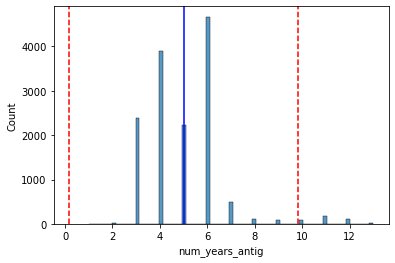

In [18]:
m=df['num_years_antig'].mean()
s=df['num_years_antig'].std()

upper_lim = m+3*s
lower_lim = m-3*s
    
plt.figure()
sns.histplot(df_engineered['num_years_antig'])
plt.axvline(m, 0,1, color='b')
plt.axvline(upper_lim, 0,1, color='r',linestyle='--')
plt.axvline(lower_lim, 0,1, color='r',linestyle='--')

In [19]:
df_engineered= df_engineered[(df_engineered['num_years_antig']>lower_lim)&(df_engineered['num_years_antig']<upper_lim)]
len(df_engineered)/len(df)

0.9508421196768452

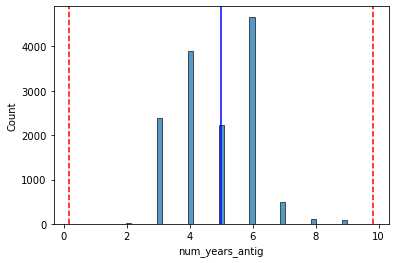

In [20]:
plt.figure()
sns.histplot(df_engineered['num_years_antig'])
plt.axvline(m, 0,1, color='b')
plt.axvline(upper_lim, 0,1, color='r',linestyle='--')
plt.axvline(lower_lim, 0,1, color='r',linestyle='--')

## 3.1.3. Price features

In [21]:
price_cols = []
for col in df.columns:
    if "price" in col and 'date' not in col:
        price_cols.append(col)
price_cols

['forecast_price_energy_off_peak',
 'forecast_price_energy_peak',
 'forecast_price_pow_off_peak',
 'price_off_peak_var',
 'price_peak_var',
 'price_mid_peak_var',
 'price_off_peak_fix',
 'price_peak_fix',
 'price_mid_peak_fix']

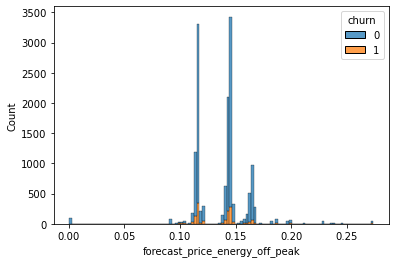

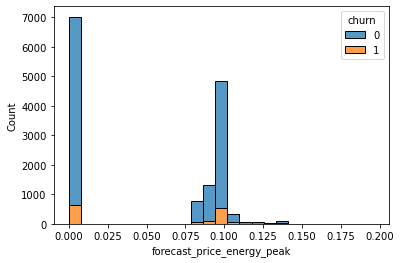

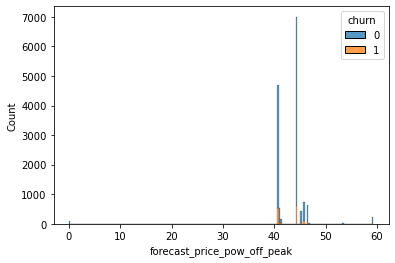

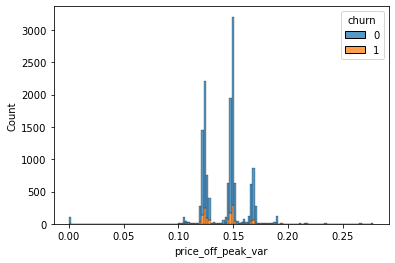

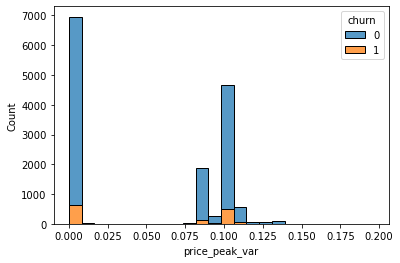

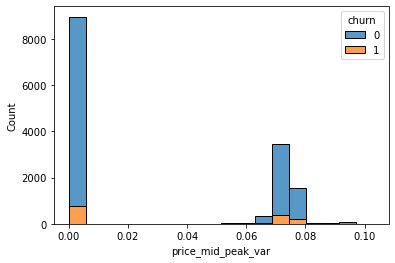

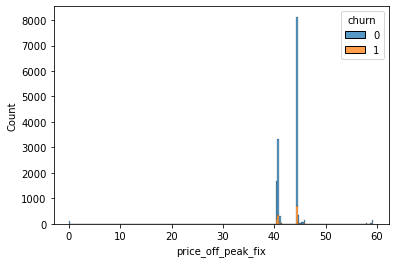

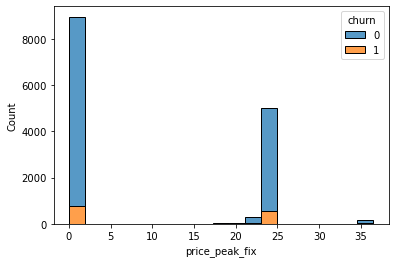

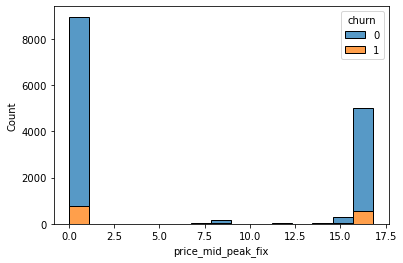

In [22]:
for col in price_cols:
    plt.figure()
    sns.histplot(x=col, data=df, hue='churn', multiple='stack')

Consist of multiple peaks: use box plot for simple operations

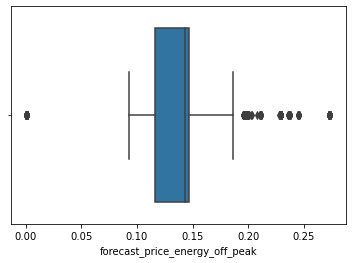

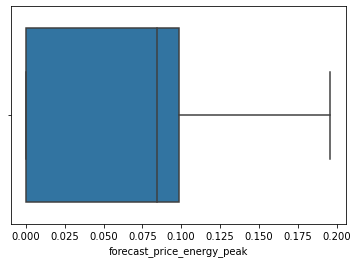

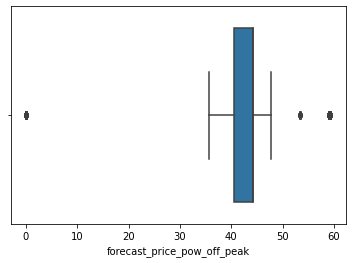

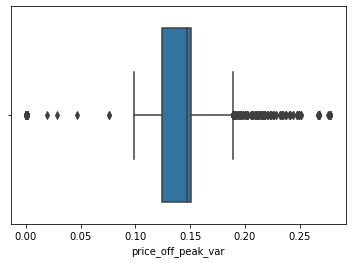

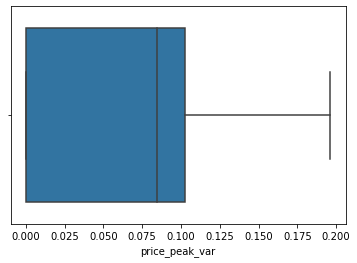

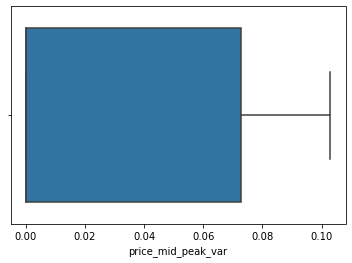

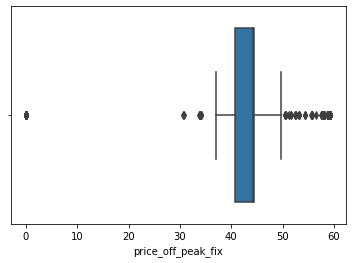

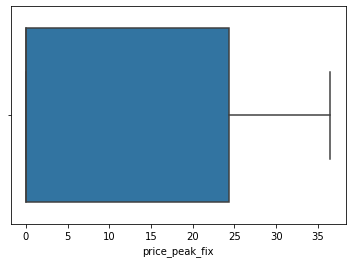

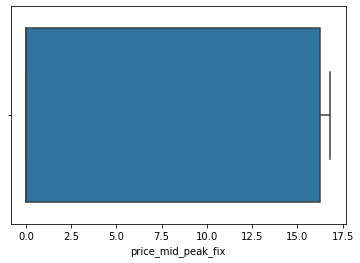

In [23]:
for col in price_cols:
    plt.figure()
    sns.boxplot(x=df[col])

'forecast_price_energy_off_peak', 'forecast_price_pow_off_peak', 'price_off_peak_var', 'price_off_peak_fix' have considerable amount of outliers

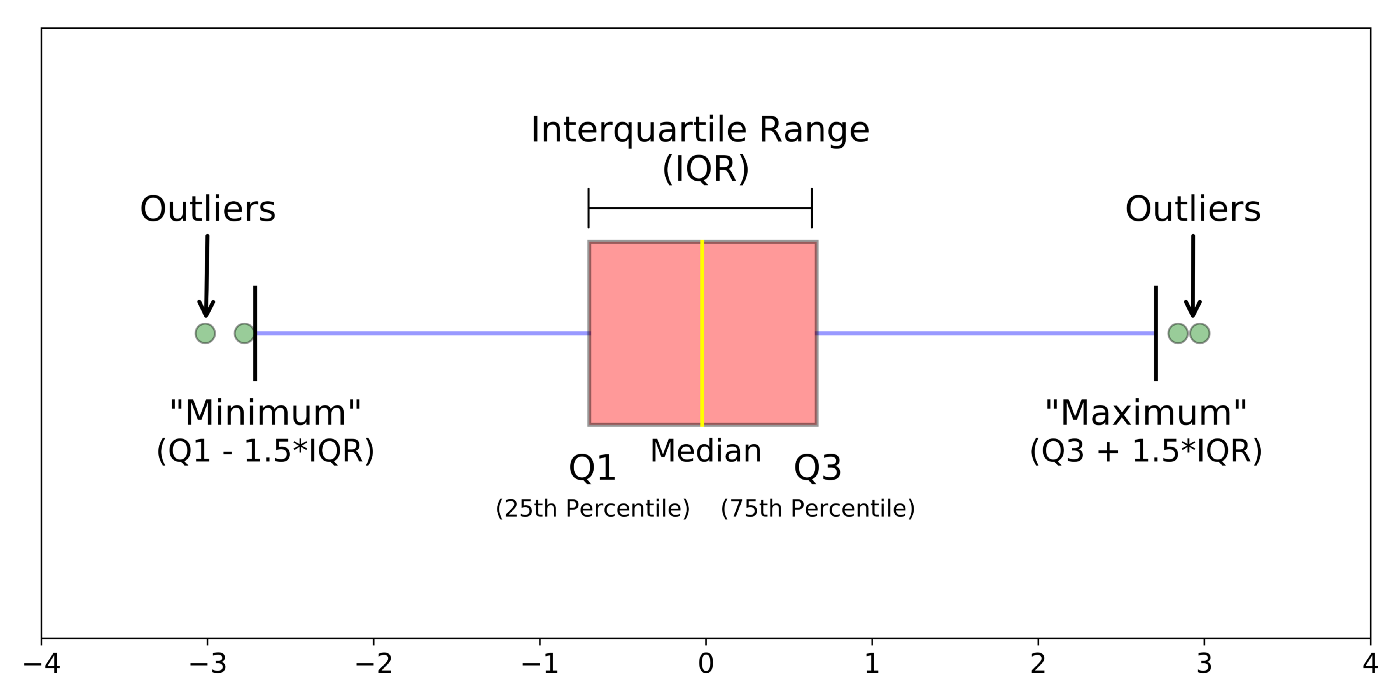

In [24]:
for col in ['forecast_price_energy_off_peak', 'forecast_price_pow_off_peak', 'price_off_peak_var', 'price_off_peak_fix']:
    # Calculate upper and lower limit from df
    iqr = df[col].describe()["75%"] - df[col].describe()["25%"]
    upper_lim = df[col].describe()["75%"] + 1.5*iqr
    lower_lim = df[col].describe()["25%"] - 1.5*iqr
    
    # Trim data in df_engineered with upper and lower lim
    df_engineered = df_engineered[(df_engineered[col]>lower_lim)&(df_engineered[col]<upper_lim)]
    
len(df_engineered)/len(df)

0.9042174448856635

In [25]:
df.columns

Index(['id', 'channel_sales', 'cons_12m', 'cons_gas_12m', 'cons_last_month',
       'date_activ', 'date_end', 'date_modif_prod', 'date_renewal',
       'forecast_cons_12m', 'forecast_cons_year', 'forecast_discount_energy',
       'forecast_meter_rent_12m', 'forecast_price_energy_off_peak',
       'forecast_price_energy_peak', 'forecast_price_pow_off_peak', 'has_gas',
       'imp_cons', 'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act',
       'net_margin', 'num_years_antig', 'origin_up', 'pow_max', 'churn',
       'price_off_peak_var', 'price_peak_var', 'price_mid_peak_var',
       'price_off_peak_fix', 'price_peak_fix', 'price_mid_peak_fix',
       'offpeak_diff_dec_january_energy', 'offpeak_diff_dec_january_power'],
      dtype='object')

## 3.1.4. Margin features

In [26]:
margin_cols = []
for col in df.columns:
    if 'margin' in col:
        margin_cols.append(col)
margin_cols

['margin_gross_pow_ele', 'margin_net_pow_ele', 'net_margin']

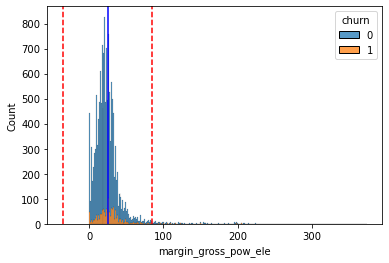

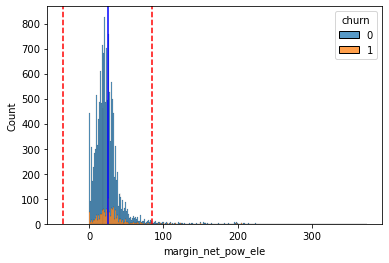

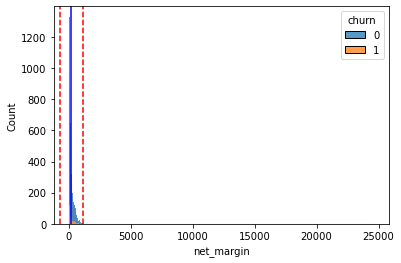

In [27]:
for col in margin_cols:
    m=df[col].mean()
    s=df[col].std()
    upper_lim = m+3*s
    lower_lim = m-3*s
    plt.figure()
    sns.histplot(x=col, data=df, hue='churn', multiple='stack')
    plt.axvline(m, 0,1, color='b')
    plt.axvline(upper_lim, 0,1, color='r',linestyle='--')
    plt.axvline(lower_lim, 0,1, color='r',linestyle='--')

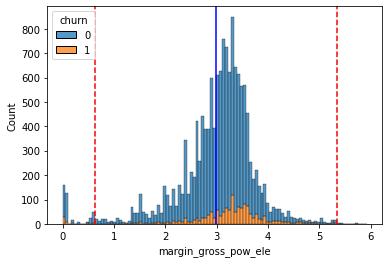

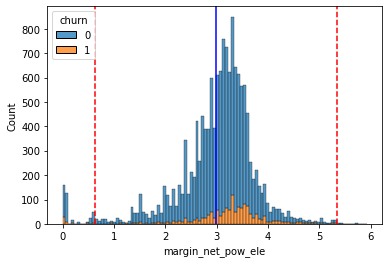

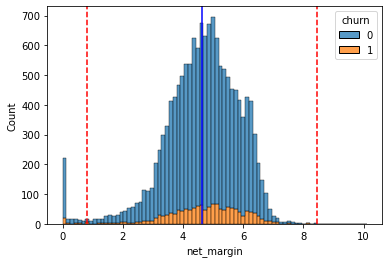

In [28]:
for col in margin_cols:
    m=np.log(df[col]+1).mean()
    s=np.log(df[col]+1).std()
    upper_lim = m+3*s
    lower_lim = m-3*s
    plt.figure()
    sns.histplot(x=np.log(df[col]+1), data=df, hue='churn', multiple='stack')
    plt.axvline(m, 0,1, color='b')
    plt.axvline(upper_lim, 0,1, color='r',linestyle='--')
    plt.axvline(lower_lim, 0,1, color='r',linestyle='--')

In [29]:
for col in margin_cols:
    # Calculate upper and lower limit from df
    m=np.log(df[col]+1).mean()
    s=np.log(df[col]+1).std()
    upper_lim = m+3*s
    lower_lim = m-3*s
    
    # Trim data in df_engineered with upper and lower lim
    df_engineered[col] = np.log(df[(np.log(df[col]+1)<upper_lim)&(np.log(df[col]+1)>lower_lim)][col]+1)

In [30]:
df_engineered.isnull().sum()

id                                   0
channel_sales                        0
cons_12m                             0
cons_gas_12m                         0
cons_last_month                      0
forecast_cons_12m                    0
forecast_cons_year                   0
forecast_discount_energy             0
forecast_meter_rent_12m              0
forecast_price_energy_off_peak       0
forecast_price_energy_peak           0
forecast_price_pow_off_peak          0
has_gas                              0
imp_cons                             0
margin_gross_pow_ele               171
margin_net_pow_ele                 171
nb_prod_act                          0
net_margin                         124
num_years_antig                      0
origin_up                            0
pow_max                              0
churn                                0
price_off_peak_var                   0
price_peak_var                       0
price_mid_peak_var                   0
price_off_peak_fix       

In [31]:
df_engineered.dropna(inplace=True,axis=0)
len(df_engineered)/len(df)

0.8840887306586335

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [33]:
#X=df_fed.drop(['id','cons_12m','date_activ', 'date_end', 'date_modif_prod', 'date_renewal','churn'],axis=1)
X=df_engineered.drop(['id','churn'],axis=1)
X = pd.get_dummies(X, drop_first=True)
y=df_engineered['churn']

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1, random_state=101)

In [43]:
rfc = RandomForestClassifier(class_weight='balanced',max_depth=n)

In [44]:
rfc.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced', max_depth=20)

In [45]:
y_pred = rfc.predict(X_test)

In [47]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      1181
           1       0.70      0.06      0.12       111

    accuracy                           0.92      1292
   macro avg       0.81      0.53      0.54      1292
weighted avg       0.90      0.92      0.88      1292



# Conclusion

* The model has very low recall score to predict the client who is going to churn. (a.k.a. Low sensitivity)
* The main source of bad-performances were dealt with in feature engineering: outliers and imbalanced data set
* There might be other unknown features: More research should be done and request other features that might be relevant to the churn

In [ ]:
df[df['churn']==1]